# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных
#### Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

#### Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

#### Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

#### Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

#### Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

from IPython.display import display

Мы импортировали cvs файл и метод `display` для вывода на печать таблиц.

In [2]:
display(data_users.head(10))
data_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [3]:
display(data_calls.head(10))
data_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
display(data_messages.head(10))
data_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
display(data_internet.head(10))
data_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
display(data_tariffs.head(10))
data_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод

Все таблицы имеют разный размер как по количеству строк, так и по количеству столбцов. Объединяет данные всех таблиц, столбец **user_id**. Каждые строки таблицы содержат информацию о клиентах компании "Мегалайн" и о их транзакциях по тарифам сотовой связи. Одна из проблем в предобработке данных это неправильный тип данных, также видны пропуске в столбце **churn_date**. Для проверки рабочих гепотез особенно ценны данные о количестве разных операций каждого клиента, длительности минут разговоров, объём использования интернет трафика и местонахождение клиента. Также нужно узнать выручку по каждому пользователю, для последующей проверки гипотез, нам особенно поможет в этом таблица `data_tariffs`.


### Шаг 2. Предобработка данных

#### Шаг 2.1. Замена типа данных

In [7]:
#Переводим значения в формат даты
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format = '%Y-%m-%dT%H:%M:%S')
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format = '%Y-%m-%dT%H:%M:%S')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format = '%Y-%m-%dT%H:%M:%S')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format = '%Y-%m-%dT%H:%M:%S')

In [8]:
# Переводим значения в формат тип object
data_users['user_id'] = data_users['user_id'].astype('object')
data_calls['user_id'] = data_calls['user_id'].astype('object')
data_messages['user_id'] = data_messages['user_id'].astype('object')
data_internet['user_id'] = data_internet['user_id'].astype('object')

#Проверим как сработали замены всех типов данных
data_users.info()
data_calls.info()
data_messages.info()
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null object
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         12

### Вывод

Мы заменили тип данных *object* на *datetime*, для того чтобы производить дальнейшие операции именно с датами, а не со строками или числами. Также во всех таблицах в столбце **user_id** мы поменяли тип данных с *int* на *object*, так как данные являются категориальными и с id клиента невозможно производить математические операции.

#### Шаг 2.2. Найдите и исправьте ошибки в данных

In [9]:
#посмотрим уникальные значения
print(data_users['churn_date'].unique())

[nan '2018-10-05' '2018-12-18' '2018-11-21' '2018-10-03' '2018-10-14'
 '2018-12-09' '2018-12-11' '2018-12-26' '2018-08-31' '2018-12-03'
 '2018-12-23' '2018-11-07' '2018-12-16' '2018-12-20' '2018-11-30'
 '2018-12-21' '2018-08-17' '2018-09-02' '2018-10-04' '2018-11-13'
 '2018-11-22' '2018-10-28' '2018-11-26' '2018-11-27' '2018-11-16'
 '2018-10-27' '2018-12-30' '2018-09-27' '2018-12-25' '2018-12-14'
 '2018-12-24' '2018-09-26' '2018-10-25']


In [10]:
#посмотрим частоту использования значений 
print(data_calls['duration'].value_counts())
print(data_calls['duration'].median()) #6
print(data_calls['duration'].mean()) #6.76

# удалим нулевые значения
data_calls = data_calls[data_calls.duration != 0.00]
print(data_calls['duration'].value_counts())
print(data_calls['duration'].median()) #7.74
print(data_calls['duration'].mean()) #8.39

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64
6.0
6.755887210214849
4.49     142
5.50     142
6.38     141
6.15     141
4.92     139
        ... 
25.67      1
27.19      1
28.87      1
26.07      1
27.63      1
Name: duration, Length: 2870, dtype: int64
7.74
8.39779402922807


In [11]:
#посмотрим частоту использования значений 
print(data_internet['mb_used'].value_counts())
print(data_internet['mb_used'].median()) #348
print(data_internet['mb_used'].mean()) #370

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64
348.015
370.1924263701839


### Вывод

Во всех таблицах найдено три неопределенные ошибки. 

- В таблице `data_users`:

В столбце **churn_date** есть пропуски, это означает, что тариф ещё действовал на момент выгрузки данных.

- В таблице `data_calls`:

В столбце **duration** есть нулевые значения, это могут быть пропущенные звонки или звонки длительностью не более 1-2 секунды (иногда некоторые операторы не списывают с баланса денег за такой короткий звонок).

- В таблице `data_internet`:

В столбце **mb_used** также присутствуют нулевые значения, это может быть неудачное соединения с интернетом, в итоге которого не получилось загрузить данные.

Мы удалили нулевые значения из столбца **duration**, так как для последующего анализа, нам нужно будет посчитать кол-во звонков, поэтому нулевые значения будут мешать для последующих расчетов, к примеру, таких как - средняя продолжительность одного звонка. 

В столбце **mb_used** удалять нулевые значения не будем, так как для последующего анализа, нам нужно считать не кол-во, а объем(сумму) потраченного интернет трафика и в этом случае '0' нам не помешает. 

На первый взгляд избавление от нулевых значений приводит к увеличению среднего и медианы.

#### Шаг 2.3. Cоздание общей сводной таблицы

In [12]:
#Добавим новые столбцы с номером месяца
data_calls['month'] = data_calls['call_date'].dt.month
data_messages['month'] = data_messages['message_date'].dt.month
data_internet['month'] = data_internet['session_date'].dt.month
#Проверяем как сработал метод
display(data_calls)
display(data_messages)
display(data_internet)

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
7,1000_7,2018-08-22,18.31,1000,8
8,1000_8,2018-09-15,18.44,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,10
149392,149392,1499_153,490.13,2018-12-14,1499,12
149393,149393,1499_154,0.00,2018-10-27,1499,10
149394,149394,1499_155,1246.32,2018-11-26,1499,11


In [13]:
#создадим сводную таблицу по минутам с группировкой id+месяц
data_calls_total = data_calls.pivot_table(index = ['user_id', 'month'], values = ['duration'], aggfunc = ['sum', 'count'])
data_calls_total.columns = ['sum_minutes', 'count_calls']
display(data_calls_total.head(15))


sum_minutes  count_calls
user_id month                          
1000    5           150.06           17
        6           158.90           28
        7           318.80           41
        8           389.87           42
        9           440.14           46
        10          328.45           44
        11          319.04           37
        12          312.98           38
1001    11          408.12           45
        12          391.34           47
1002    6           110.37           14
        7           204.75           21
        8           269.71           37
        9           195.85           25
        10          199.48           24

In [14]:
#создадим сводную таблицу по сообщениям с группировкой id+месяц
data_messages_total = data_messages.pivot_table(index = ['user_id', 'month'], values = ['id'], aggfunc = ['count'])
data_messages_total.columns = ['count_messages']
display(data_messages_total.head(15))


count_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
        10                 73
        11                 58
        12                 70
1002    6                   4
        7                  11
        8                  13
        9                   4
        10                 10
        11                 16
        12                 12

In [15]:
#создадим сводную таблицу по интернет трафику с группировкой id+месяц
data_internet_total = data_internet.pivot_table(index = ['user_id', 'month'], values = ['mb_used'], aggfunc = ['sum'])
data_internet_total.columns = ['sum_mb']
display(data_internet_total.head(15))

sum_mb
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25

In [16]:
#Создадим общую сводную таблицу объединия столбцы из разных таблиц
total_data = data_calls_total.reset_index().merge(data_messages_total, on =['user_id', 'month'], how = 'left')
total_data = total_data.reset_index().merge(data_internet_total, on =['user_id', 'month'], how = 'left')
total_data = total_data.pivot_table(index = ['user_id', 'month'], \
                                    values = ['sum_mb', 'count_messages', 'sum_minutes', 'count_calls'])
display(total_data)
                                      

count_calls  count_messages    sum_mb  sum_minutes
user_id month                                                    
1000    5               17            22.0   2253.49       150.06
        6               28            60.0  23233.77       158.90
        7               41            75.0  14003.64       318.80
        8               42            81.0  14055.93       389.87
        9               46            57.0  14568.91       440.14
...                    ...             ...       ...          ...
1498    10              30            42.0  20579.36       232.63
1499    9                8            11.0   1845.75        64.65
        10              44            48.0  17788.51       429.91
        11              62            59.0  17963.31       576.50
        12              56            66.0  13055.58       465.16

[3168 rows x 4 columns]

In [17]:
#Добавим в общую таблицу, данные по тарифу
tariff = data_users[['user_id' , 'tariff']]
total_data = total_data.reset_index().merge(tariff, on =['user_id'], how = 'left')

In [18]:
display(total_data.head(15))
total_data.info()
#Заменим пропуски на ноль
total_data['count_messages'] = total_data['count_messages'].fillna(0)
total_data['sum_mb'] = total_data['sum_mb'].fillna(0)
# Заменим тип данных
total_data['count_messages'] = total_data['count_messages'].astype('int')

display(total_data.head(15))
total_data.info()

,user_id,month,count_calls,count_messages,sum_mb,sum_minutes,tariff
0,1000,5,17,22.0,2253.49,150.06,ultra
1,1000,6,28,60.0,23233.77,158.90,ultra
2,1000,7,41,75.0,14003.64,318.80,ultra
3,1000,8,42,81.0,14055.93,389.87,ultra
4,1000,9,46,57.0,14568.91,440.14,ultra
5,1000,10,44,73.0,14702.49,328.45,ultra
6,1000,11,37,58.0,14756.47,319.04,ultra
7,1000,12,38,70.0,9817.61,312.98,ultra
8,1001,11,45,NaN,18429.34,408.12,smart
9,1001,12,47,NaN,14036.66,391.34,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 7 columns):
user_id           3168 non-null object
month             3168 non-null int64
count_calls       3168 non-null int64
count_messages    2673 non-null float64
sum_mb            3157 non-null float64
sum_minutes       3168 non-null float64
tariff            3168 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 198.0+ KB


,user_id,month,count_calls,count_messages,sum_mb,sum_minutes,tariff
0,1000,5,17,22,2253.49,150.06,ultra
1,1000,6,28,60,23233.77,158.90,ultra
2,1000,7,41,75,14003.64,318.80,ultra
3,1000,8,42,81,14055.93,389.87,ultra
4,1000,9,46,57,14568.91,440.14,ultra
5,1000,10,44,73,14702.49,328.45,ultra
6,1000,11,37,58,14756.47,319.04,ultra
7,1000,12,38,70,9817.61,312.98,ultra
8,1001,11,45,0,18429.34,408.12,smart
9,1001,12,47,0,14036.66,391.34,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 7 columns):
user_id           3168 non-null object
month             3168 non-null int64
count_calls       3168 non-null int64
count_messages    3168 non-null int64
sum_mb            3168 non-null float64
sum_minutes       3168 non-null float64
tariff            3168 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 198.0+ KB


In [19]:
f'Количество уникальных пользователей: {total_data.user_id.nunique()}'

'Количество уникальных пользователей: 492'

### Вывод

Мы создали общую сводную таблицу, которая содержит данные по каждому пользователю и считает количество сделанных звонков и израсходованных минут разговора, количество отправленных сообщений, объем израсходованного интернет-трафика и название тарифа. Срез расчета - по месяцам. 

Для этого нам потребовалось создать новые столбцы с номером месяца, объединить все четыре таблицы с помощь метода `merge`, а также мы удалили пропущенные значения и заменили их на ноль с помощью метода `fillna`. В этих столбцах были пропущенные значения, потому что пользователи в этом месяце не отправляли ни одного сообщения или не пользовались мобильным интернетом. 

Также мы заменили тип данных столбца **count_messages** на *int*, так как нельзя отправить к примеру половинку смс. 

#### Шаг 2.4. Расчет выручки по каждому пользователю

In [20]:
#Посмотрим еще раз на нужные данные
display(total_data.head(15))
display(data_tariffs.head(10))

,user_id,month,count_calls,count_messages,sum_mb,sum_minutes,tariff
0,1000,5,17,22,2253.49,150.06,ultra
1,1000,6,28,60,23233.77,158.90,ultra
2,1000,7,41,75,14003.64,318.80,ultra
3,1000,8,42,81,14055.93,389.87,ultra
4,1000,9,46,57,14568.91,440.14,ultra
5,1000,10,44,73,14702.49,328.45,ultra
6,1000,11,37,58,14756.47,319.04,ultra
7,1000,12,38,70,9817.61,312.98,ultra
8,1001,11,45,0,18429.34,408.12,smart
9,1001,12,47,0,14036.66,391.34,smart


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
# Добавим стоимость тарифа в таблицу
def rub_monthly_fee(row):
    if row["tariff"] == "ultra":
        return "1950"
    if row["tariff"] == "smart":
        return "550"

total_data['rub_monthly_fee'] = total_data.apply(rub_monthly_fee, axis = 1)
# поменяем тип данных
total_data['rub_monthly_fee'] = total_data['rub_monthly_fee'].astype('int')


In [22]:
# Добавми столбец с доп. платой за смс сверх лимита. 

def comm_messages(row):
    if row['count_messages'] > 50 and row["tariff"] == 'smart':
        return (row['count_messages'] - 50) * 3
    if row['count_messages'] > 1000 and row["tariff"] == 'ultra':
        return (row['count_messages'] - 1000)
    else:
        return 0 

    
total_data['comm_messages'] = total_data.apply(comm_messages, axis = 1)


In [23]:
# поработаем над столбцом кол-во минут
total_data['sum_minutes'] = total_data['sum_minutes'].apply(np.ceil)
total_data['sum_minutes'] = total_data['sum_minutes'].astype('int')

#Добавми столбец с доп. платой за минуты сверх лимита. 
def comm_calls(row):
    if row['sum_minutes'] > 500 and row["tariff"] == 'smart':
        return (row['sum_minutes'] - 500) * 3
    if row['sum_minutes'] > 3000 and row["tariff"] == 'ultra':
        return (row['sum_minutes'] - 3000)
    else:
        return 0 

    
total_data['comm_calls'] = total_data.apply(comm_calls, axis = 1)
total_data['comm_calls'] = total_data['comm_calls'].astype('int')


In [24]:
# поработаем над столбцом интернет трафика и добавим новый столбец
total_data['sum_gd'] = (total_data['sum_mb'] / 1024).apply(np.ceil)
total_data['sum_gd'] = total_data['sum_gd'].astype('int')

# Добавми столбец с доп. платой за интернет сверх лимита. 
def comm_internet(row):
    if row['sum_gd'] > 15 and row["tariff"] == 'smart':
        return (row['sum_gd'] - 15) * 200
    if row['sum_gd'] > 30 and row["tariff"] == 'ultra':
        return (row['sum_gd'] - 30) * 150
    else:
        return 0 

    
total_data['comm_internet'] = total_data.apply(comm_internet, axis = 1)

In [25]:
# добавим столбец с выручкой
total_data['revenue'] = (total_data['rub_monthly_fee'] + total_data['comm_messages'] +\
                         total_data['comm_calls'] + total_data['comm_internet'])

In [26]:
# Проверим как все сработало
display(total_data)
total_data.info()


,user_id,month,count_calls,count_messages,sum_mb,sum_minutes,tariff,rub_monthly_fee,comm_messages,comm_calls,sum_gd,comm_internet,revenue
0,1000,5,17,22,2253.49,151,ultra,1950,0,0,3,0,1950
1,1000,6,28,60,23233.77,159,ultra,1950,0,0,23,0,1950
2,1000,7,41,75,14003.64,319,ultra,1950,0,0,14,0,1950
3,1000,8,42,81,14055.93,390,ultra,1950,0,0,14,0,1950
4,1000,9,46,57,14568.91,441,ultra,1950,0,0,15,0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,10,30,42,20579.36,233,smart,550,0,0,21,1200,1750
3164,1499,9,8,11,1845.75,65,smart,550,0,0,2,0,550
3165,1499,10,44,48,17788.51,430,smart,550,0,0,18,600,1150
3166,1499,11,62,59,17963.31,577,smart,550,27,231,18,600,1408


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 13 columns):
user_id            3168 non-null object
month              3168 non-null int64
count_calls        3168 non-null int64
count_messages     3168 non-null int64
sum_mb             3168 non-null float64
sum_minutes        3168 non-null int64
tariff             3168 non-null object
rub_monthly_fee    3168 non-null int64
comm_messages      3168 non-null int64
comm_calls         3168 non-null int64
sum_gd             3168 non-null int64
comm_internet      3168 non-null int64
revenue            3168 non-null int64
dtypes: float64(1), int64(10), object(2)
memory usage: 346.5+ KB


In [27]:
# Создадим отдельную тублицу с выручкой и другими важными показателями для дальнейшего анализа
data_revenue = total_data.pivot_table(index = ['user_id', 'tariff', 'month'], \
                                      values = ['count_messages', 'sum_minutes', 'sum_gd', 'revenue'])
display(data_revenue.head(20))


count_messages  revenue  sum_gd  sum_minutes
user_id tariff month                                              
1000    ultra  5                  22     1950       3          151
               6                  60     1950      23          159
               7                  75     1950      14          319
               8                  81     1950      14          390
               9                  57     1950      15          441
               10                 73     1950      15          329
               11                 58     1950      15          320
               12                 70     1950      10          313
1001    smart  11                  0     1150      18          409
               12                  0      550      14          392
1002    smart  6                   4      550      11          111
               7                  11     1150      18          205
               8                  13     1550      20          270
               9                   4      950      17          196
               10                 10      550      14          200
               11                 16     1350      19          229
               12                 12     1150      18          223
1003    ultra  8                  37     1950       9          356
               9                  91     1950      13          905
               10                 83     1950      15          810

  ### Вывод

Мы посчитали помесячную выручку с каждого пользователя и создали сводную таблицу. Для расчета нам понадобилось применять логические функции и создавать новые столбцы. Также походу работы над расчетом выручки, мы меняли типы данных и округляли значения некоторых столбцов до ближайшего большего с помощью метода `np.ceil`. Так как, если человек использовал сверх лимита 2,3 гб, то денег он должен заплатить за полные 3 гб, с минутами аналогично. 

На первый взгляд видно, что люди, которые пользуются тарифом smart, чаще выходят за пределы тарифного пакета, чем люди, которые пользуются тарифом ultra. Также на первый взгляд видно, что чаще всего заканчивается лимит по интернет трафику, потом наверное минуты и в самом конце смс. Это логично, так как в 2020 году, интернет трафик на первом месте, а смс уже потихоньку изжили себя.

### Шаг 3. Анализ данных

In [28]:
#Создадим таблицу по тарифам со средними значениями сразу за все месяца
data_tarif_total = total_data.pivot_table(index = ['user_id', 'tariff'], \
                                          values = ['count_messages', 'sum_minutes', 'sum_gd',], aggfunc = ['mean'])
display(data_tarif_total)


mean                       
               count_messages     sum_gd sum_minutes
user_id tariff                                      
1000    ultra            62.0  13.625000  302.750000
1001    smart             0.0  16.000000  400.500000
1002    smart            10.0  16.714286  204.857143
1003    ultra            76.0  11.800000  720.600000
1004    ultra           149.0  18.750000  115.750000
...                       ...        ...         ...
1495    ultra            68.0  25.400000  738.200000
1496    smart            39.0  22.500000  472.250000
1497    smart            17.0  15.333333  442.333333
1498    smart            42.0  18.750000  306.000000
1499    smart            46.0  12.750000  384.500000

[492 rows x 3 columns]

In [29]:
# Сделаем отдельный срез по тарифу ультра
data_tarif_ultra = data_tarif_total.query('tariff == "ultra"')
data_tarif_ultra.columns = ['count_messages', 'sum_gd', 'sum_minutes']
    
#Посчитаем срзнач, дисперсию и СКО по смс
print('среднее значение кол-ва смс тарифа ultra:', data_tarif_ultra['count_messages'].mean(axis = 0))
print('дисперсия кол-ва смс тарифа ultra:', np.var(data_tarif_ultra['count_messages'], ddof=1))
print('стандартное отклонение кол-ва смс тарифа ultra:', np.std(data_tarif_ultra['count_messages'], ddof=1))


среднее значение кол-ва смс тарифа ultra: 54.016958041958034
дисперсия кол-ва смс тарифа ultra: 2076.617144378509
стандартное отклонение кол-ва смс тарифа ultra: 45.569914904227204


In [30]:
#Посчитаем срзнач, дисперсию и СКО по минутам
print('среднее значение кол-ва минут тарифа ultra:', data_tarif_ultra['sum_minutes'].mean(axis = 0))
print('дисперсия кол-ва минут тарифа ultra:', np.var(data_tarif_ultra['sum_minutes'], ddof=1))
print('стандартное отклонение кол-ва минут тарифа ultra:', np.std(data_tarif_ultra['sum_minutes'], ddof=1))

среднее значение кол-ва минут тарифа ultra: 516.8825603689239
дисперсия кол-ва минут тарифа ultra: 63944.482105277035
стандартное отклонение кол-ва минут тарифа ultra: 252.8724621331414


In [31]:
#Посчитаем срзнач, дисперсию и СКО по трафику в гб
print('среднее значение кол-ва гб тарифа ultra:', data_tarif_ultra['sum_gd'].mean(axis = 0))
print('дисперсия кол-ва гб тарифа ultra:', np.var(data_tarif_ultra['sum_gd'], ddof=1))
print('стандартное отклонение кол-ва гб тарифа ultra:', np.std(data_tarif_ultra['sum_gd'], ddof=1))

среднее значение кол-ва гб тарифа ultra: 19.55411558138831
дисперсия кол-ва гб тарифа ultra: 66.96876098052189
стандартное отклонение кол-ва гб тарифа ultra: 8.183444322565034


In [32]:
# Сделаем отдельный срез по тарифу смарт
data_tarif_smart = data_tarif_total.query('tariff == "smart"')
data_tarif_smart.columns = ['count_messages', 'sum_gd', 'sum_minutes']

#Посчитаем срзнач, дисперсию и СКО по смс
print('среднее значение кол-ва смс тарифа smart:', data_tarif_smart['count_messages'].mean(axis = 0))
print('дисперсия кол-ва смс тарифа smart:', np.var(data_tarif_smart['count_messages'], ddof=1))
print('стандартное отклонение кол-ва смс тарифа smart:', np.std(data_tarif_smart['count_messages'], ddof=1))

среднее значение кол-ва смс тарифа smart: 32.378556647109654
дисперсия кол-ва смс тарифа smart: 704.9430035009631
стандартное отклонение кол-ва смс тарифа smart: 26.55076276683898


In [33]:
#Посчитаем срзнач, дисперсию и СКО по минутам
print('среднее значение кол-ва минут тарифа smart:', data_tarif_smart['sum_minutes'].mean(axis = 0))
print('дисперсия кол-ва минут тарифа smart:', np.var(data_tarif_smart['sum_minutes'], ddof=1))
print('стандартное отклонение кол-ва минут тарифа smart:', np.std(data_tarif_smart['sum_minutes'], ddof=1))

среднее значение кол-ва минут тарифа smart: 397.70754681485346
дисперсия кол-ва минут тарифа smart: 18373.305184448047
стандартное отклонение кол-ва минут тарифа smart: 135.54816555176262


In [34]:
#Посчитаем срзнач, дисперсию и СКО по трафику в гб
print('среднее значение кол-ва гб тарифа smart:', data_tarif_smart['sum_gd'].mean(axis = 0))
print('дисперсия кол-ва гб тарифа smart:', np.var(data_tarif_smart['sum_gd'], ddof=1))
print('стандартное отклонение кол-ва гб тарифа smart:', np.std(data_tarif_smart['sum_gd'], ddof=1))

среднее значение кол-ва гб тарифа smart: 16.313255146636234
дисперсия кол-ва гб тарифа smart: 12.346725012513517
стандартное отклонение кол-ва гб тарифа smart: 3.5137906899121805


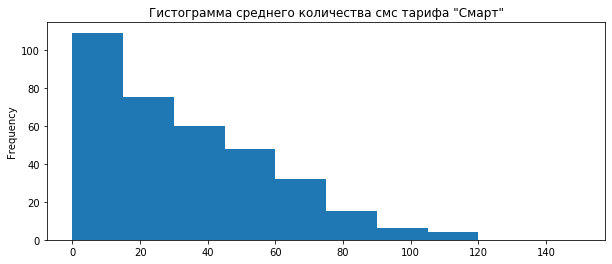

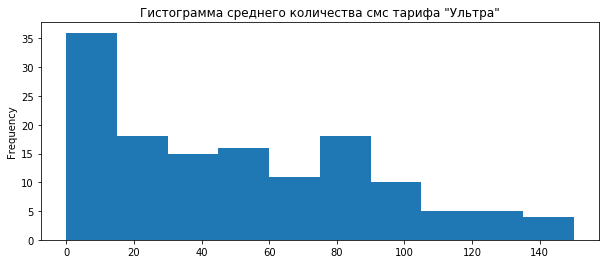

In [47]:
import matplotlib.pyplot as plt
data_tarif_smart['count_messages'].plot(kind='hist', bins=10, range=(0,150), figsize=(10,4),\
                                        title='Гистограмма среднего количества смс тарифа "Смарт"')
plt.show()
data_tarif_ultra['count_messages'].plot(kind='hist', bins=10, range=(0,150), figsize=(10,4),\
                                        title='Гистограмма среднего количества смс тарифа "Ультра"')
plt.show()

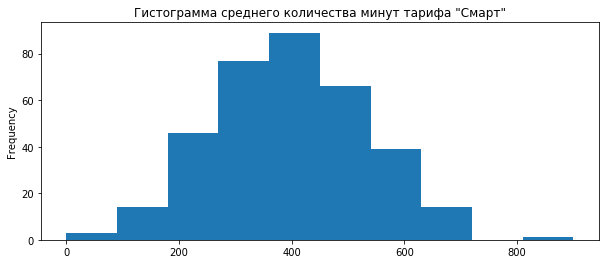

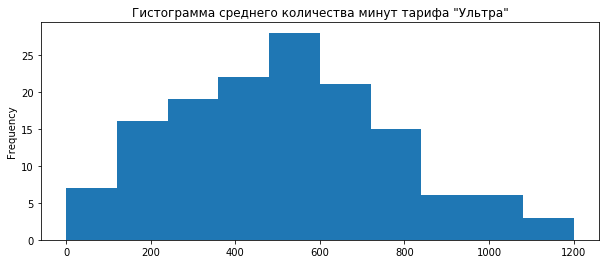

In [48]:
data_tarif_smart['sum_minutes'].plot(kind='hist', bins=10, range=(0,900), figsize=(10,4), \
                                     title='Гистограмма среднего количества минут тарифа "Смарт"')
plt.show()
data_tarif_ultra['sum_minutes'].plot(kind='hist', bins=10, range=(0,1200), figsize=(10,4), \
                                     title='Гистограмма среднего количества минут тарифа "Ультра"')
plt.show()

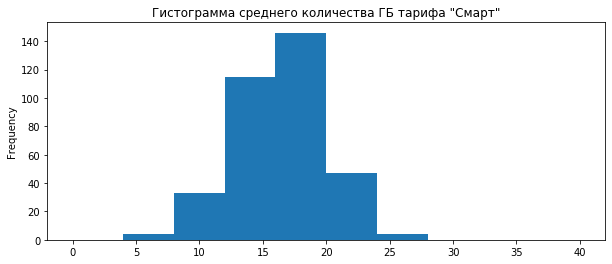

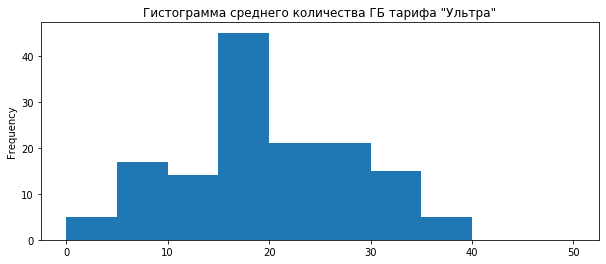

In [49]:
data_tarif_smart['sum_gd'].plot(kind='hist', bins=10, range=(0,40), figsize=(10,4), \
                                title='Гистограмма среднего количества ГБ тарифа "Смарт"')
plt.show()
data_tarif_ultra['sum_gd'].plot(kind='hist', bins=10, range=(0,50), figsize=(10,4), \
                                title='Гистограмма среднего количества ГБ тарифа "Ультра"')
plt.show()

### Вывод


Мы посчитали по каждому параметру среднее значение, дисперсию и стандартное отклонение. Так как мы использовали для анализа выборку, то мы применяли параметр `ddof=1` в расчетах. Так как в каждой выборке у нас более 50 значений, то сравнение будет обоснованным т.к. закон больших чисел и ЦПТ гарантируют, что параметры распределений будут близки к параметрам генеральных совокупностей. 

Если смотреть на тариф смарт, то видно, что пользователи не укладываются в пакет тарифа. Если обратиться к правилу трех сигм (срзнач + 3 СКО), то видно, что пользователи:

- отправляют сообщений до 110, а в тарифе 50
- тратят минут до 802, в тарифе 500
- тратят интернета до 27 гб, когда в тарифе 15

Также к примеру очень большое стандартное отклонение по кол-ву минут в тарифе смарт, это указывает, что в данных есть выбросы, что собственно и видно на гистограмме. 

В тарифе ультра, пользователи обычно не выходят за рамки пакета по смс и минутам, но им приходится докупать интернет трафик:

- отправляют сообщений до 189, а в тарифе 1000
- тратят минут до 1272, в тарифе 3000
- тратят интернета до 44 гб, когда в тарифе 30

На гистограммах среднего количества смс двух тарифов, видно распределение Пуассона, так как она несимметрична. Остальные гистограммы стремятся к нормальному распределению. Наиболее частые (типичные, нормальные) значения оказываются посередине. А редкие — по краям. 

### Шаг 4. Проверяем гипотезы

#### Шаг 4.1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается или нет

In [38]:
#Создадим таблицу со средней выручкой по тарифам каждого пользователя сразу за все месяца
data_revenue_tarif = total_data.pivot_table(index = ['user_id', 'tariff', 'month'], values = ['revenue'])
display(data_revenue_tarif)

revenue
user_id tariff month         
1000    ultra  5         1950
               6         1950
               7         1950
               8         1950
               9         1950
...                       ...
1498    smart  10        1750
1499    smart  9          550
               10        1150
               11        1408
               12         598

[3168 rows x 1 columns]

In [39]:
# создадим выборки по каждому тарифу с помощью срезов
data_revenue_ultra = data_revenue_tarif.query('tariff == "ultra"')
data_revenue_ultra.columns = ['revenue']
display(data_revenue_ultra)

data_revenue_smart = data_revenue_tarif.query('tariff == "smart"')
data_revenue_smart.columns = ['revenue']
display(data_revenue_smart)

revenue
user_id tariff month         
1000    ultra  5         1950
               6         1950
               7         1950
               8         1950
               9         1950
...                       ...
1495    ultra  8         1950
               9         2400
               10        1950
               11        3300
               12        1950

[947 rows x 1 columns]

revenue
user_id tariff month         
1001    smart  11        1150
               12         550
1002    smart  6          550
               7         1150
               8         1550
...                       ...
1498    smart  10        1750
1499    smart  9          550
               10        1150
               11        1408
               12         598

[2221 rows x 1 columns]

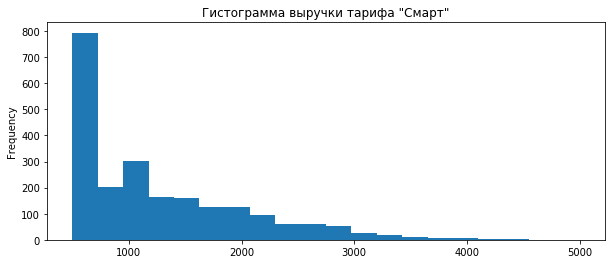

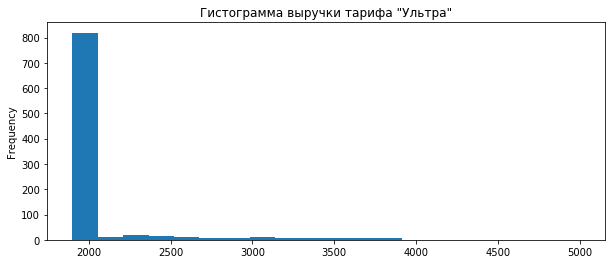

In [50]:
#строим гистрограммы выручки
data_revenue_smart['revenue'].plot(kind='hist', bins=20, range=(500,5000), figsize=(10,4), \
                                   title='Гистограмма выручки тарифа "Смарт"')
plt.show()
data_revenue_ultra['revenue'].plot(kind='hist', bins=20, range=(1900,5000), figsize=(10,4), \
                                   title='Гистограмма выручки тарифа "Ультра"')
plt.show()

In [41]:
# Проверяем гипотезу
from scipy import stats as st
import numpy as np

alpha = .05

results = st.ttest_ind(data_revenue_smart['revenue'], data_revenue_ultra['revenue'])

print('Средняя выручка по тарифу смарт:', data_revenue_smart['revenue'].mean())
print('Средняя выручка по тарифу ультра:', data_revenue_ultra['revenue'].mean())

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка по тарифу смарт: 1258.6064835659613
Средняя выручка по тарифу ультра: 2071.4889123548046
p-значение: 3.167435008495475e-172
Отвергаем нулевую гипотезу


### Вывод

Средняя выручка по тарифу смарт далеко неодинаковая по сравнению с тарифом ультра. Хоть по смарту люди чаще вылезают за пределы пакета в тарифе и платят дополнительную комиссию, но стоимость тарифа ультра выше в 4 раза изначально. Вот и средняя выручка тоже намного выше. Нулевую гипотезу отвергаем.

Применять параметр `equal_var` мы не стали, так как со значением True или False результат будет эквивалентен друг другу из-за того, что выборки у нас больше 50 наблюдений.

Мы отвергаем нулевую гипотезу, так как такие различия не могли быть получы случайно. Значения различны и это различие определяется влиянием неслучайных факторов, например, разница стоимости тарифа изначально. 

#### Шаг 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [42]:
#Добавим в общую таблицу, данные по городу пользователя
city = data_users[['user_id' , 'city']]
total_data = total_data.reset_index().merge(city, on =['user_id'], how = 'left')


In [43]:
#создидим функцию по классификации региона
def region(row):
    if row['city'] == 'Москва':
        return 'москва'   
    return 'другие регионы'

#Добавим новый столбец 
total_data['region'] = total_data.apply(region, axis = 1)

display(total_data.head(10))

,index,user_id,month,count_calls,count_messages,sum_mb,sum_minutes,tariff,rub_monthly_fee,comm_messages,comm_calls,sum_gd,comm_internet,revenue,city,region
0,0,1000,5,17,22,2253.49,151,ultra,1950,0,0,3,0,1950,Краснодар,другие регионы
1,1,1000,6,28,60,23233.77,159,ultra,1950,0,0,23,0,1950,Краснодар,другие регионы
2,2,1000,7,41,75,14003.64,319,ultra,1950,0,0,14,0,1950,Краснодар,другие регионы
3,3,1000,8,42,81,14055.93,390,ultra,1950,0,0,14,0,1950,Краснодар,другие регионы
4,4,1000,9,46,57,14568.91,441,ultra,1950,0,0,15,0,1950,Краснодар,другие регионы
5,5,1000,10,44,73,14702.49,329,ultra,1950,0,0,15,0,1950,Краснодар,другие регионы
6,6,1000,11,37,58,14756.47,320,ultra,1950,0,0,15,0,1950,Краснодар,другие регионы
7,7,1000,12,38,70,9817.61,313,ultra,1950,0,0,10,0,1950,Краснодар,другие регионы
8,8,1001,11,45,0,18429.34,409,smart,550,0,0,18,600,1150,Москва,москва
9,9,1001,12,47,0,14036.66,392,smart,550,0,0,14,0,550,Москва,москва


In [44]:
# Создадим отдельную таблицу по региону и выручке
data_revenue_region = total_data.pivot_table(index = ['user_id', 'region', 'month'], values = ['revenue'])
display(data_revenue_region.head(10))


revenue
user_id region         month         
1000    другие регионы 5         1950
                       6         1950
                       7         1950
                       8         1950
                       9         1950
                       10        1950
                       11        1950
                       12        1950
1001    москва         11        1150
                       12         550

In [45]:
# Cделаем две выборки по регионам
data_revenue_other_region = data_revenue_region.query('region == "другие регионы"')
data_revenue_other_region.columns = ['revenue']
display(data_revenue_other_region)

data_revenue_moscow = data_revenue_region.query('region == "москва"')
data_revenue_moscow.columns = ['revenue']
display(data_revenue_moscow)

revenue
user_id region         month         
1000    другие регионы 5         1950
                       6         1950
                       7         1950
                       8         1950
                       9         1950
...                               ...
1498    другие регионы 10        1750
1499    другие регионы 9          550
                       10        1150
                       11        1408
                       12         598

[2558 rows x 1 columns]

revenue
user_id region month         
1001    москва 11        1150
               12         550
1003    москва 8         1950
               9         1950
               10        1950
...                       ...
1490    москва 8          950
               9          550
               10        1750
               11        1350
               12         750

[610 rows x 1 columns]

In [46]:
#Проверяем гипотезу

alpha = .05


results = st.ttest_ind(data_revenue_other_region['revenue'], data_revenue_moscow['revenue'])

print('Средняя выручка по регионам:', data_revenue_other_region['revenue'].mean())
print('Средняя выручка по Москве:', data_revenue_moscow['revenue'].mean())

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")

Средняя выручка по регионам: 1495.7455043002346
Средняя выручка по Москве: 1526.144262295082
p-значение: 0.3963088462441611
Не получилось отвергнуть нулевую гипотезу


### Вывод

Для проверки гипотезы, потребовалось создать новую классификацию регионов с помощью функции и добавлением нового столбца. 

Похоже на то, что средняя выручка в Москве и других регионах практически одинакова. Мы сформировали нулевую гипотезу и отвергнуть ее не получилось, так как отсутствуют различия в сравнении между двумя выборками. 

Мы не можем отвергуть нулевую гипотезу, а альтернавиную отвергаем, так как полученные нами значения схожи и с высокой вероятность, которая равна значению уровня значимости, случайны. 


### Шаг 5. Общий вывод

Анализируя два тарифных плана и поведение пользователей компании "Мегалайн" можно сказать следующие:

С точки зрения выручки, больше денег приносит конечно же тариф ультра. Стоимость абонентской платы в разы выше, тарифа смарт. Хоть люди и укладываются в пакетное предложение по смс и минутам, но гб все равно иногда не хватает, благодаря этим двум факторам, можно смело сказать, что оборот средств по тарифу ультра для компании выше, чем по тарифу смарт. 

Но с точки зрения прибыли, было бы интересно посмотреть на дополнительную информацию о себестоимости двух продуктов и их составляющих. Ведь скорее всего затрат на тариф смарт меньше, так как пакетное предложение скромнее чем в ультра. А дополнительная стоимость смс с минутами в ТРИ раза выше, стоимость дополнительного ГБ выше на одну треть. И пользователи данного тарифа, часто докупают новые смс, минуты, гб. 

С точки зрения самих пользователей, а вернее для их лояльности к компании, можно некоторым предложить перейти на тариф ультра, что бы те меньше тратили своих денежных средств. Для некоторых это будет выгоднее.

С точки зрения географического расположения разница выручки минимальная, поэтому вкладывать в рекламную компанию можно ровно пропорционально масштабу региона. 